In [2]:
import torch
print(torch.__version__)

1.12.0+cu113


In [1]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함
# mmcv(full) 버전 지정
!pip install mmcv-full==1.6.0 -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
# mmdetection 설치 
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.1 MB 8.2 MB/s 
     |████████████████████████████████| 190 kB 4.7 MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 28935, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 28935 (delta 0), reused 4 (delta 0), pack-reused 28927
Receiving objects: 100% (28935/28935), 39.40 MiB | 31.87 MiB/s, done.
Resolving deltas: 100% (20659/20659), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
reading manifest templ

In [1]:
# 아래를 수행하기 전에 kernel을 restart 해야 함. 
from mmdet.apis import init_detector, inference_detector
import mmcv

### KITTI Dataset 다운로드


In [2]:
# /content 아래 압축 파일 다운 및 압축 해제
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-07-26 23:35:58--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.41
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  9.50MB/s    in 0.7s    

2022-07-26 23:36:00 (9.50 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



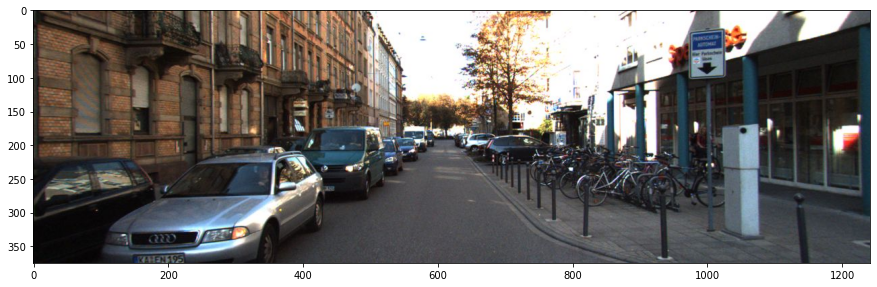

In [3]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

### KITTI DATA FORMAT


In [4]:
#  첫번째 컬럼은 해당 오브젝트의 클래스 명. 
#  5번째~8번째가 BOUNDING BOX 정보임. 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 임. 
!cat /content/kitti_tiny/training/label_2/000068.txt

Car 0.25 0 1.94 69.26 200.28 435.08 374.00 1.46 1.62 4.04 -3.00 1.79 6.98 1.55
Car 0.80 1 2.26 0.00 209.20 198.59 374.00 1.46 1.58 3.72 -5.44 1.85 6.22 1.56
Cyclist 0.97 0 2.34 1210.28 199.77 1241.00 374.00 1.55 0.57 1.73 4.04 1.69 3.57 -3.14
Car 0.00 2 1.68 478.18 187.68 549.54 249.43 1.57 1.60 3.99 -2.73 2.03 20.96 1.55
Car 0.00 1 1.66 530.03 187.79 573.10 226.09 1.52 1.54 3.68 -2.53 2.20 31.50 1.58
Van 0.00 1 1.63 547.61 171.12 584.05 212.41 2.47 1.98 5.81 -2.79 2.41 46.44 1.57
Car 0.00 1 -0.16 667.74 182.35 790.82 230.38 1.62 1.65 4.14 4.19 1.99 25.95 0.00
Car 0.00 2 -0.11 657.37 184.48 763.34 221.64 1.55 1.66 4.47 4.35 2.10 32.00 0.02
Car 0.00 1 -0.01 637.45 180.34 714.44 212.34 1.69 1.76 4.12 3.59 2.12 39.79 0.08
Van 0.00 1 1.61 572.52 175.02 596.26 199.95 2.13 1.91 6.40 -2.28 2.36 65.43 1.57
Van 0.00 1 1.77 380.78 167.69 523.29 288.56 1.95 1.75 4.63 -2.89 1.90 14.05 1.57
Cyclist 0.00 1 1.09 958.95 167.55 1036.88 254.43 1.68 0.53 1.96 7.95 1.59 14.95 1.57


### KITTI annotation 파일들의 리스트들을 가지는 파일 확인. 

In [5]:
!cat /content/kitti_tiny/train.txt

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049


### mmdetection의 중립 annotation 포맷 변환.




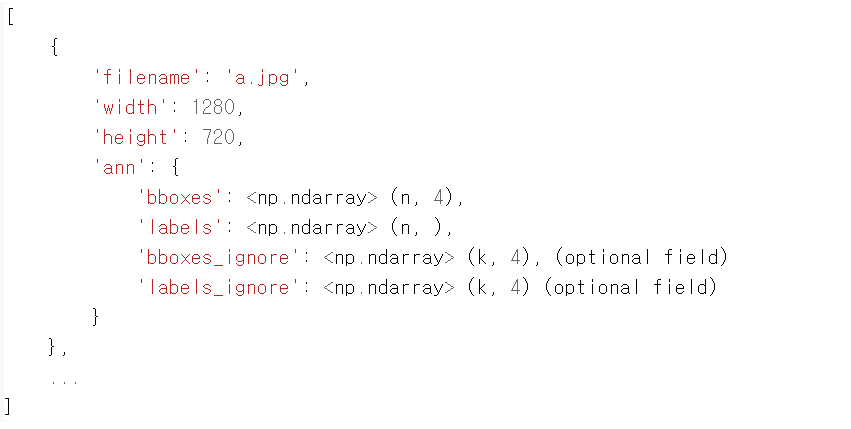

### kitti Dataset을 중립 데이터형태로 변환하여 메모리 로드

In [6]:
# 원본 kitti Dataset는 10개의 Class로 되어 있음. 'Car Van Truck Pedestrian Person_sitting Cyclist Tram Misc DontCare'
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}
print(cat2label)
cat2label['Car']


{'Car': 0, 'Truck': 1, 'Pedestrian': 2, 'Cyclist': 3}


0

In [7]:
image_list = mmcv.list_from_file('/content/kitti_tiny/train.txt')


In [8]:
lines = mmcv.list_from_file('/content/kitti_tiny/training/label_2/000064.txt')
#print(lines)
content = [line.strip().split(' ') for line in lines]
bbox_names = [x[0] for x in content]
#print(bbox_names)
bboxes = [ [float(info) for info in x[4:8]] for x in content]
print(bboxes)

[[657.65, 179.93, 709.86, 219.92], [731.51, 180.39, 882.28, 275.8], [715.18, 175.63, 762.77, 203.9], [816.58, 59.74, 1112.51, 266.07], [626.78, 174.27, 647.77, 192.18], [546.19, 168.97, 554.01, 177.09]]


In [9]:
import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# Decorator 설정.@DATASETS.register_module() 설정 시 force=True를 입력하지 않으면 Dataset 재등록 불가-데이터셋 등록. 
@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):
  # 튜플의 순서대로 클래스 넘버링
  CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
  
  # __init__ 메소드는 상속받고 그대로 사용하기에 명기 하지 않음

  ##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
  #### ann_file: /content/kitti_tiny/train.txt
  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 이 self.ann_file이 load_annotations()의 인자로 입력
  def load_annotations(self, ann_file):
    print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
    print('#### ann_file:', ann_file)
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    # 어노테이션 파일의 내용(train 등의 해당 데이터 및 어노테이션 id)
    image_list = mmcv.list_from_file(self.ann_file)
    # 포맷 중립 데이터를 담을 list 객체-개별 이미지에 대한 dict를 가짐
    data_infos = []
    
    for image_id in image_list:
      filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)
      # 원본 이미지의 너비, 높이를 image를 직접 로드하여 구함. 
      image = cv2.imread(filename)
      height, width = image.shape[:2]
      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename 에는 image의 파일명만 들어감(디렉토리는 제외)
      data_info = {'filename': str(image_id) + '.jpeg',
                   'width': width, 'height': height}
      # 개별 annotation이 있는 서브 디렉토리의 prefix 변환. 
      label_prefix = self.img_prefix.replace('image_2', 'label_2')
      # 개별 annotation 파일을 1개 line 씩 읽어서 list 로드-개별 이미지의 오브젝트 별로의 정보들을 리스트로 담음 
      lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))

      # 전체 lines를 개별 line별 공백 레벨로 parsing 하여 다시 list로 저장. content는 list의 list형태임.
      # ann 정보는 numpy array로 저장되나 텍스트 처리나 데이터 가공이 list 가 편하므로 일차적으로 list로 변환 수행.   
      content = [line.strip().split(' ') for line in lines] #줄별로의 오브젝트 정보를 리스트에 넣고 원소별로(공백 단위) 쪼갬
      # 오브젝트의 클래스명은 bbox_names로 저장. 
      bbox_names = [x[0] for x in content]
      # bbox 좌표를 저장
      bboxes = [ [float(info) for info in x[4:8]] for x in content]

      # 클래스명이 해당 사항이 없는 대상 Filtering out, 'DontCare'sms ignore로 별도 저장.
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      for bbox_name, bbox in zip(bbox_names, bboxes):
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        if bbox_name in cat2label:
          gt_bboxes.append(bbox)
          # gt_labels에는 class id를 입력
          gt_labels.append(cat2label[bbox_name])
        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)
      # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값은 모두 np.array임. 
      data_anno = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
          'labels': np.array(gt_labels, dtype=np.long),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }
      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장. 
      data_info.update(ann=data_anno)
      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
      data_infos.append(data_info)

    return data_infos


In [10]:
### Config 설정하고 Pretrained 모델 다운로드
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [11]:
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2022-07-26 23:36:52--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.41
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  8.79MB/s    in 19s     

2022-07-26 23:37:11 (8.60 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [19]:
from mmcv import Config
# 해당 경로의 config 파일을 fromfile을 통해 config 객체화
cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [33]:
from mmdet.apis import set_random_seed
# config 파일 수정.
# dataset에 대한 환경 파라미터 수정. 
# config 파일에 새로운 데이터 형태 정의-클래스 단위-CunstomDataset 형태 상속받은 타입이며 등록됨
# 데이터 경로 지정
# 데이터 루트는 절대경로가 좋음-해당 루트 기반으로 필요한 파일을 연결하여 지정
cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
# 해당 경로 및 파일명은 class를 통해 concate 됨
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
# 레이블 디렉토리에 데이터에 대한 레이블 존재하나 현재 형식은 어노테이션 파일이 1개여야 하기에 train 텍스트 파일로 함-해당 파일엔 train id가 리스트로 존재하기에 해당 id들로부터 이미지 데이터 및 레이블 사용 가능
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

# val 데이터는 내부적으로 알아서 찾음-학습 데이터만 입력해도
cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4
# pretrained 모델-mmdetection 아래에 있다고 판단-아래 코드에서 %cd 로 해서 상대경로는 상대경로대로 찾고 절대경로는 절대 경로대로 찾기에 문제없음
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
# '.'-/content
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정-GPU 8개 중 1개 사용. 
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정. 
cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost-12번 학습 되기에 간격 지정-model save
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정. 
cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

cfg.data.train.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ]

cfg.data.val.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1500, 900),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]
  
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500, 900),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

### Config에서 설정한 Dataset과 Model, 동적 학습율, Pipeline 설정에 따라 모델 학습 수행. 


In [34]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
# config 파일의 학습 데이터를 인자로 주어 학습용 데이터 셋 생성
datasets = [build_dataset(cfg.data.train)]

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/train.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

In [24]:
# count는 해당 클래스에 대한 오브젝트 개수
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [ ]:
datasets[0].CLASSES

In [35]:
# detector 생성-config 파일의 load한 모델과 학습, 테스트 config를 인자로 넣어줌
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# datasets에는 1개 원소가 있기에 해당 원소의 class들을 튜플로 반환하여 학습 및 예측 해야할 모델의 클래스를 정의
model.CLASSES = datasets[0].CLASSES

In [36]:
!pwd

/content/mmdetection


In [37]:
# 주의, config에 pretrained 모델 지정이 상대 경로로 설정됨 cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 아래와 같이 %cd mmdetection 지정 필요. 
 
# %cd mmdetection 

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
# '.'-/content
# config 파일에서 지정한 경로로 디렉토리 생성-해당 디렉토리에 config 파일을 통해서 모델 등 저장-epoch_12나 latest 파일 모두 같은 파일-모델
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
# 데이터 학습 진행-config 파일 내의 load 한 모델과 train 데이터를 build를 통해 생성하여 그것들을 인자로 넣어서 train
# 
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-07-27 01:03:59,320 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by i

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/val.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/val.txt


2022-07-27 01:03:59,645 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2022-07-27 01:03:59,650 - mmdet - INFO - Start running, host: root@7dbe1e337e39, work_dir: /content/mmdetection/tutorial_exps
2022-07-27 01:03:59,652 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 11.2 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-07-27 01:06:17,177 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 149  | 0.935  | 0.831 |
| Truck      | 3   | 21   | 1.000  | 0.500 |
| Pedestrian | 13  | 46   | 0.923  | 0.783 |
| Cyclist    | 7   | 42   | 0.714  | 0.208 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.580 |
+------------+-----+------+--------+-------+
2022-07-27 01:06:17,180 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5800, mAP: 0.5803


### 학습된 model을 이용하여 inference 수행. 

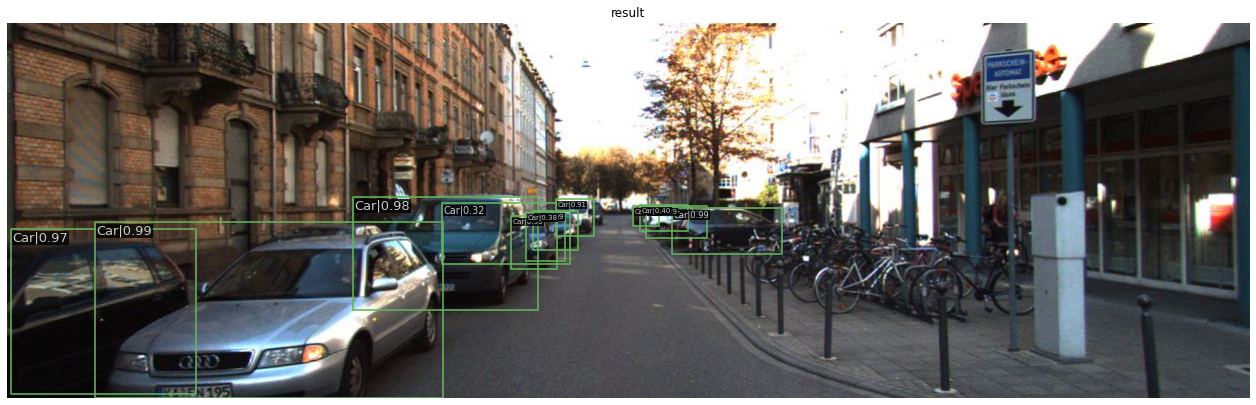

In [41]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')
# build_detector로 생성한 객체에 config 파일 대입
model.cfg = cfg
# 모델에 이미지를 inference
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [ ]:
cfg.data.test.pipeline[0].type

### 학습된 모델을 이용하여 Video Detection 수행하기

In [42]:
%cd /content
!mkdir /content/data
!wget -O /content/data/the_rock_chase.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true

/content
--2022-07-27 01:25:58--  https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4 [following]
--2022-07-27 01:25:58--  https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4 [following]
--2022-07-27 01:25:58--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [43]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
labels_to_names_seq = {i:k for i, k in enumerate(CLASSES)}
labels_to_names_seq

{0: 'Car', 1: 'Truck', 2: 'Pedestrian', 3: 'Cyclist'}

In [44]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}

def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음. 
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list. 
  results = inference_detector(model, img_array)

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, result in enumerate(results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(result) == 0:
      continue
    
    # 2차원 array에서 5번째 컬럼에 해당하는 값이 score threshold이며 이 값이 함수 인자로 들어온 score_threshold 보다 낮은 경우는 제외. 
    result_filtered = result[np.where(result[:, 4] > score_threshold)]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(result_filtered)):
      # 좌상단, 우하단 좌표 추출. 
      left = int(result_filtered[i, 0])
      top = int(result_filtered[i, 1])
      right = int(result_filtered[i, 2])
      bottom = int(result_filtered[i, 3])
      caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
      cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
      cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
      if is_print:
        print(caption)

  return draw_img

In [45]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold, is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [46]:
do_detected_video(model, '/content/data/the_rock_chase.mp4', '/content/data/the_rock_chase_out1.mp4', score_threshold=0.4, do_print=True)

총 Frame 갯수: 503
frame별 detection 수행 시간: 0.1696
frame별 detection 수행 시간: 0.1443
frame별 detection 수행 시간: 0.1114
frame별 detection 수행 시간: 0.1078
frame별 detection 수행 시간: 0.1153
frame별 detection 수행 시간: 0.1102
frame별 detection 수행 시간: 0.1073
frame별 detection 수행 시간: 0.1079
frame별 detection 수행 시간: 0.1098
frame별 detection 수행 시간: 0.1054
frame별 detection 수행 시간: 0.107
frame별 detection 수행 시간: 0.1087
frame별 detection 수행 시간: 0.1052
frame별 detection 수행 시간: 0.1081
frame별 detection 수행 시간: 0.1056
frame별 detection 수행 시간: 0.1081
frame별 detection 수행 시간: 0.1067
frame별 detection 수행 시간: 0.1065
frame별 detection 수행 시간: 0.1099
frame별 detection 수행 시간: 0.1085
frame별 detection 수행 시간: 0.1089
frame별 detection 수행 시간: 0.1097
frame별 detection 수행 시간: 0.1055
frame별 detection 수행 시간: 0.1092
frame별 detection 수행 시간: 0.1065
frame별 detection 수행 시간: 0.1113
frame별 detection 수행 시간: 0.1082
frame별 detection 수행 시간: 0.1075
frame별 detection 수행 시간: 0.1099
frame별 detection 수행 시간: 0.1075
frame별 detection 수행 시간: 0.1056
frame별 detection 수행 시간: 